# Energy Balance Comparison
### Author: Daniel Hogan
### Creation Date: July 29, 2024

This notebook will compare the net energy balance and accumulated total energy exchanges during winters 2022 and 2023 using data from SAIL, SPLASH, and SOS.

### Imports

In [1]:
# general
import os
import glob
import datetime as dt
import json
# data 
import xarray as xr 
from sublimpy import utils, variables, tidy, turbulence
import numpy as np
import pandas as pd
from act import discovery, plotting
# plotting
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# helper tools
from scripts.get_sail_data import get_sail_data
from scripts.helper_funcs import create_windrose_df, simple_sounding, mean_sounding
import scripts.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()
# stats
import scipy.stats as stats
import seaborn as sns


nctoolkit is using Climate Data Operators version 2.3.0


### Data

In [2]:
##### 2022 data ####
winter_22 = slice('2021-12-01', '2022-03-31')
# SAIL data
w22_sail_gts_met = xr.open_dataset('./01_data/processed_data/sail/sail_ds_1H_met_2022.nc').sel(time=winter_22)
w22_sail_kp_ecor = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/eddy_covariance_kettle_ponds_20211001_20220930.nc').sel(time=winter_22)
w22_sail_kp_ecor = w22_sail_kp_ecor.to_dataframe().resample('1H').mean().to_xarray()
w22_sail_gts_sebs = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/sebs_20211001_20220930.nc').sel(time=winter_22)
w22_sail_gts_sebs = w22_sail_gts_sebs.to_dataframe().resample('1H').mean().to_xarray()
# SPLASH data
w22_splash_kp_asfs = xr.open_dataset('./01_data/processed_data/splash/w22_splash_kp_qc_1H.nc').sel(time=winter_22)
w22_splash_ap_asfs = xr.open_dataset('./01_data/processed_data/splash/w22_splash_ap_qc_1H.nc').sel(time=winter_22)
w22_splash_kp_radsys = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/splash_data/radsys_ckp_dataset.nc').sel(time=winter_22)
# average the w22_splash_kp_radsys data to hourly means
w22_splash_kp_radsys = w22_splash_kp_radsys.to_dataframe().resample('1H').mean().to_xarray()

##### 2023 data ####
winter_23 = slice('2022-12-01', '2023-03-31')
# SAIL data
w23_sail_gts_met = xr.open_dataset('./01_data/processed_data/sail/sail_ds_1H_met_2023.nc').sel(time=winter_23)
w23_sail_kp_ecor = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_22_23/eddy_covariance_kettle_ponds_20221001_20230930.nc').sel(time=winter_23)
w23_sail_kp_ecor = w23_sail_kp_ecor.to_dataframe().resample('1H').mean().to_xarray()
w23_sail_gts_sebs = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_22_23/sebs_20221001_20230930.nc').sel(time=winter_23)
w23_sail_gts_sebs = w23_sail_gts_sebs.to_dataframe().resample('1H').mean().to_xarray()
# SPLASH data
w23_splash_ap_asfs = xr.open_dataset('./01_data/processed_data/splash/w23_splash_ap_qc_1H.nc').sel(time=winter_23)
w23_splash_kp_radsys = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/splash_data/radsys_ckp_dataset.nc').sel(time=winter_23)
# aberage the w23_splash_kp_radsys data to hourly means
w23_splash_kp_radsys = w23_splash_kp_radsys.to_dataframe().resample('1H').mean().to_xarray()
# SOS data
w23_sos_kp_all = xr.open_dataset('./01_data/processed_data/sos/sos_ds_1H_storage.nc').sel(time=winter_23)


In [3]:
# drop bad data for soil heat flux from SAIL
ds_for_soil = w22_sail_gts_sebs.where((w22_sail_gts_sebs['qc_surface_soil_heat_flux_1']==0) & (w22_sail_gts_sebs['qc_surface_soil_heat_flux_2']==0) & (w22_sail_gts_sebs['qc_surface_soil_heat_flux_3']==0))
w22_sail_gts_sebs['surface_soil_heat_flux_avg'] = (ds_for_soil.surface_soil_heat_flux_1 + ds_for_soil.surface_soil_heat_flux_2 + ds_for_soil.surface_soil_heat_flux_3)/3

ds_for_soil = w23_sail_gts_sebs.where((w23_sail_gts_sebs['qc_surface_soil_heat_flux_1']==0) & (w23_sail_gts_sebs['qc_surface_soil_heat_flux_2']==0) & (w23_sail_gts_sebs['qc_surface_soil_heat_flux_3']==0))
w23_sail_gts_sebs['surface_soil_heat_flux_avg'] = (ds_for_soil.surface_soil_heat_flux_1 + ds_for_soil.surface_soil_heat_flux_2 + ds_for_soil.surface_soil_heat_flux_3)/3

In [4]:
# calculate longwave radiation for SOS data
SIGMA = 5.67e-8
w23_sos_kp_all = w23_sos_kp_all.assign(R_lw_up = ((w23_sos_kp_all.Rpile_out_9m_d + (w23_sos_kp_all.Tcase_out_9m_d+273.15)**4*SIGMA)))
w23_sos_kp_all = w23_sos_kp_all.assign(R_lw_down = ((w23_sos_kp_all.Rpile_in_9m_d + (w23_sos_kp_all.Tcase_in_9m_d+273.15)**4*SIGMA)))

# calculate latent heat flux
Ls = 2.83e3 # J/kg
rho = 1000 # kg/m3
latent_heat_vars = [var for var in hf.TURBULENCE_VARIABLES if 'w_h2o__' in var]
for var in latent_heat_vars:
    new_var = var.replace('w_h2o__', 'LE_')
    w23_sos_kp_all = w23_sos_kp_all.assign({new_var: (w23_sos_kp_all[var]*Ls*rho/1000)})

# calculate sensible heat flux
gas_constant_dry_air = 287.058 # J/kg/K
density_of_air = (w23_sos_kp_all.P_10m_c*100)/(gas_constant_dry_air*(w23_sos_kp_all.T_10m_c+273.15))
heat_capacity_air = 1005 # J/kg/K
sensible_heat_vars = [var for var in hf.TURBULENCE_VARIABLES if 'w_tc_' in var]
for var in sensible_heat_vars:
    new_var = var.replace('w_tc__', 'H_')
    w23_sos_kp_all = w23_sos_kp_all.assign({new_var: (w23_sos_kp_all[var]*heat_capacity_air*density_of_air)})

For each dataset, let's build a dictionary of energy balance variables

In [5]:
energy_balance_variables = dict(
    SAIL= {'H':'sensible_heat_flux',
             'LE':'latent_heat_flux',
             'R_sw_down':'down_short_hemisp',
             'R_sw_up':'up_short_hemisp',
             'R_lw_down':'down_long',
             'R_lw_up':'up_long',
             'G':'surface_soil_heat_flux_avg',
             'R_net':'surface_energy_balance',},
    SPLASH= {'H':'Hs',
                'LE':'Hl',
                'R_sw_down':'down_short_hemisp',
                'R_sw_up':'up_short_hemisp',
                'R_lw_down':'down_long_hemisp',
                'R_lw_up':'up_long_hemisp',
                'G':['subsurface_heat_flux_A','subsurface_heat_flux_B'],
                'R_net':None,},
    SPLASH_RADSYS = {'H':'Hs',
                        'LE':'Hl',
                        'R_sw_down':'dw_solar',
                        'R_sw_up':'uw_solar',
                        'R_lw_down':'dw_ir',
                        'R_lw_up':'uw_ir',
                        'G':['subsurface_heat_flux_A','subsurface_heat_flux_B'],
                        'R_net':'TotalNet',},
    SOS= {'H':'H_5m_c',
            'LE':'LE_5m_c',
            'R_sw_down':'Rsw_in_9m_d',
            'R_sw_up':'Rsw_out_9m_d',
            'R_lw_down':'R_lw_down',
            'R_lw_up':'R_lw_up',
            'G':None,
            'R_net':None,})

# 2022
### Plots of SAIL and SPLASH energy balance components

Positive net radiation: energy is entering the snowpack. The snowpack is warming
Positive ground heat flux: energy is leaving the ground and entering the snowpack. The snowpack is warming.
Positive latent heat flux: energy is leaving the snowpack. Positive latent heat flux means the snowpack is cooling.
Positive sensible heat flux:  energy is leaving the snowpack and returning to the atmosphere. Positive sensible heat flux implies the snowpack is cooling.

Generally, I would expect net radiation to be negative. This would mean that the snowpack is (generally) cooling.
Since snow is cold, I would expect the cumulative sum of sensible heat flux to be negative (sign is flipped when doing surface energy balance). This would appear as a net input of thermal energy measured as a temperture increase into the snowpack.
Since sublimation requires energy to occur, latent heat flux should be a net draw of energy in the snowpack, meaning energy should decrease (cooling it).
Initially, ground heat flux will be large and positive (lots of ground energy entering the snow). Then this will peter out later in the season and could turn into a net draw on energy from the snowpack. 

In [6]:
# SAIL calculations
eb_dict = energy_balance_variables['SAIL']
w22_sail_sebs_net_sw = (w22_sail_gts_sebs[eb_dict['R_sw_down']] - w22_sail_gts_sebs[eb_dict['R_sw_up']]).where((w22_sail_gts_sebs['qc_'+eb_dict['R_sw_up']]==0) & (w22_sail_gts_sebs['qc_'+eb_dict['R_sw_down']]==0), 0)
w22_sail_sebs_net_lw = (w22_sail_gts_sebs[eb_dict['R_lw_down']] - w22_sail_gts_sebs[eb_dict['R_lw_up']]).where((w22_sail_gts_sebs['qc_'+eb_dict['R_lw_up']]==0) & (w22_sail_gts_sebs['qc_'+eb_dict['R_lw_down']]==0), 0)
w22_sail_sebs_rnet = w22_sail_sebs_net_sw + w22_sail_sebs_net_lw
w22_sail_ecor_sensible_heat_flux = -w22_sail_kp_ecor[eb_dict['H']].where(np.abs(w22_sail_kp_ecor[eb_dict['H']]) < 400, np.nan)
# sensible_heat_flux is missing data points, add nan to match length of net_sw

w22_sail_ecor_latent_heat_flux = -w22_sail_kp_ecor[eb_dict['LE']]

w22_sail_sebs_surface_soil_heat_flux = w22_sail_gts_sebs[eb_dict['G']].where(np.abs(w22_sail_gts_sebs[eb_dict['G']]) < 200, np.nan)

In [7]:
# SPLASH calculations
eb_dict = energy_balance_variables['SPLASH']
w22_splash_asfs_net_sw = (w22_splash_kp_asfs[eb_dict['R_sw_down']] - w22_splash_kp_asfs[eb_dict['R_sw_up']]).where((w22_splash_kp_asfs[eb_dict['R_sw_up']+'_qc']==0) & (w22_splash_kp_asfs[eb_dict['R_sw_down']+'_qc']==0), np.nan)
w22_splash_asfs_net_lw = (w22_splash_kp_asfs[eb_dict['R_lw_down']] - w22_splash_kp_asfs[eb_dict['R_lw_up']]).where((w22_splash_kp_asfs[eb_dict['R_lw_up']+'_qc']==0) & (w22_splash_kp_asfs[eb_dict['R_lw_down']+'_qc']==0), np.nan)
w22_splash_asfs_rnet = w22_splash_asfs_net_sw + w22_splash_asfs_net_lw
w22_splash_asfs_sensible_heat_flux = -w22_splash_kp_asfs[eb_dict['H']].where(np.abs(w22_splash_kp_asfs[eb_dict['H']]) < 400, np.nan)
# sensible_heat_flux is missing data points, add nan to match length of net_sw

w22_splash_asfs_latent_heat_flux = w22_splash_kp_asfs[eb_dict['LE']]

w22_splash_asfs_surface_soil_heat_flux = w22_splash_kp_asfs[eb_dict['G']].where(np.abs(w22_splash_kp_asfs[eb_dict['G']]) < 200, np.nan).to_pandas().mean(axis=1)

# SPLASH RADSYS calculations
eb_dict = energy_balance_variables['SPLASH_RADSYS']
w22_splash_radsys_net_sw = (w22_splash_kp_radsys[eb_dict['R_sw_down']] - w22_splash_kp_radsys[eb_dict['R_sw_up']]).where(w22_splash_kp_radsys['NetSolar_qc']==0, np.nan)
w22_splash_radsys_net_lw = (w22_splash_kp_radsys[eb_dict['R_lw_down']] - w22_splash_kp_radsys[eb_dict['R_lw_up']]).where(w22_splash_kp_radsys['NetIR_qc']==0, np.nan)
w22_splash_radsys_rnet = w22_splash_radsys_net_sw + w22_splash_radsys_net_lw

In [8]:
fig = go.Figure()
colors = px.colors.qualitative.Plotly

# SAIL
fig.add_trace(go.Scatter(x=w22_sail_sebs_net_sw.cumsum().time, 
                         y=w22_sail_sebs_net_sw.cumsum(), 
                         name='R_sw',
                         marker=dict(color=colors[0]),)
                         )
# SPLASH
fig.add_trace(go.Scatter(x=w22_splash_asfs_net_sw.cumsum().time, 
                         y=w22_splash_asfs_net_sw.cumsum(), 
                         name='R_asfs_sw',
                         marker=dict(color=colors[0]), 
                         line=dict(dash='dashdot'),
                         showlegend=False), 
                         )
# SPLASH RADSYS
fig.add_trace(go.Scatter(x=w22_splash_radsys_net_sw.cumsum().time, 
                         y=w22_splash_radsys_net_sw.cumsum(), 
                         name='R_radsys_sw', 
                         marker=dict(color=colors[0]),
                         line=dict(dash='dash'),
                         showlegend=False), 
                         )

# SAIL
fig.add_trace(go.Scatter(x=w22_sail_sebs_net_lw.cumsum().time, 
                         y=w22_sail_sebs_net_lw.cumsum(), 
                         name='R_lw',
                         marker=dict(color=colors[4]),)
                         )
# SPLASH
fig.add_trace(go.Scatter(x=w22_splash_asfs_net_lw.cumsum().time, 
                         y=w22_splash_asfs_net_lw.cumsum(), 
                         name='R_asfs_lw',
                         marker=dict(color=colors[4]), 
                         line=dict(dash='dashdot'),
                         showlegend=False), 
                         )
# SPLASH RADSYS
fig.add_trace(go.Scatter(x=w22_splash_radsys_net_lw.cumsum().time, 
                         y=w22_splash_radsys_net_lw.cumsum(), 
                         name='R_radsys_lw', 
                         marker=dict(color=colors[4]),
                         line=dict(dash='dash'),
                         showlegend=False), 
                         )


fig.add_trace(go.Scatter(x=w22_sail_ecor_sensible_heat_flux.cumsum().time, 
                         y=w22_sail_ecor_sensible_heat_flux.cumsum(),
                         marker=dict(color=colors[1]),
                         name='H')
                         )
fig.add_trace(go.Scatter(x=w22_splash_asfs_sensible_heat_flux.cumsum().time, 
                         y=w22_splash_asfs_sensible_heat_flux.cumsum(), 
                         name='H', 
                         marker=dict(color=colors[1]),
                         line=dict(dash='dashdot'),
                         showlegend=False), 
                         )

fig.add_trace(go.Scatter(x=w22_sail_ecor_latent_heat_flux.cumsum().time, 
                         y=w22_sail_ecor_latent_heat_flux.cumsum(), 
                         marker=dict(color=colors[2]),
                         name='LE')
                         )
fig.add_trace(go.Scatter(x=w22_splash_asfs_latent_heat_flux.cumsum().time, 
                         y=w22_splash_asfs_latent_heat_flux.cumsum(), 
                         name='LE', 
                         marker=dict(color=colors[2]),
                         line=dict(dash='dashdot'),
                         showlegend=False), 
                         )

# fig.add_trace(go.Scatter(x=w22_sail_sebs_surface_soil_heat_flux.cumsum().time, 
#                          y=w22_sail_sebs_surface_soil_heat_flux.cumsum(),
#                          marker=dict(color=colors[3]), 
#                          name='G')
#                          )
# fig.add_trace(go.Scatter(x=w22_splash_asfs_surface_soil_heat_flux.cumsum().index, 
#                          y=w22_splash_asfs_surface_soil_heat_flux.cumsum(), 
#                          name='G', 
#                          marker=dict(color=colors[3]),
#                          line=dict(dash='dashdot'),
#                          showlegend=False), 
#                          )
# locations
fig.add_trace(go.Scatter(x=[w22_sail_sebs_rnet.isel(time=0).time.values], y=[w22_sail_sebs_rnet.isel(time=0).values], mode='lines', name='SAIL', line=dict(color='gray', dash='solid'), legendgroup='loc', legendgrouptitle_text="Location"),)
fig.add_trace(go.Scatter(x=[w22_sail_sebs_rnet.isel(time=0).time.values], y=[w22_sail_sebs_rnet.isel(time=0).values], mode='lines', name='SPLASH ASFS', line=dict(color='gray', dash='dash'), legendgroup='loc'),)
fig.add_trace(go.Scatter(x=[w22_sail_sebs_rnet.isel(time=0).time.values], y=[w22_sail_sebs_rnet.isel(time=0).values], mode='lines', name='SPLASH Radsys', line=dict(color='gray', dash='dashdot'), legendgroup='loc'),)
# update hovermode
fig.update_layout(hovermode='x unified',
                  yaxis_range=[-100e3, 100e3],
                  title='Cumulative Energy Balance Components',
                  height=600,
                  width=1000,)


# 2023
### Plots of SAIL and SPLASH energy balance components

Positive net radiation: energy is entering the snowpack. The snowpack is warming
Positive ground heat flux: energy is leaving the ground and entering the snowpack. The snowpack is warming.
Positive latent heat flux: energy is leaving the snowpack. Positive latent heat flux means the snowpack is cooling.
Positive sensible heat flux:  energy is leaving the snowpack and returning to the atmosphere. Positive sensible heat flux implies the snowpack is cooling.

Generally, I would expect net radiation to be negative. This would mean that the snowpack is (generally) cooling.
Since snow is cold, I would expect the cumulative sum of sensible heat flux to be negative (sign is flipped when doing surface energy balance). This would appear as a net input of thermal energy measured as a temperture increase into the snowpack.
Since sublimation requires energy to occur, latent heat flux should be a net draw of energy in the snowpack, meaning energy should decrease (cooling it).
Initially, ground heat flux will be large and positive (lots of ground energy entering the snow). Then this will peter out later in the season and could turn into a net draw on energy from the snowpack. 

In [94]:
# SAIL calculations
eb_dict = energy_balance_variables['SAIL']
w23_sail_sebs_net_sw = (w23_sail_gts_sebs[eb_dict['R_sw_down']] - w23_sail_gts_sebs[eb_dict['R_sw_up']]).where((w23_sail_gts_sebs['qc_'+eb_dict['R_sw_up']]==0) & (w23_sail_gts_sebs['qc_'+eb_dict['R_sw_down']]==0), 0)
w23_sail_sebs_net_lw = (w23_sail_gts_sebs[eb_dict['R_lw_down']] - w23_sail_gts_sebs[eb_dict['R_lw_up']]).where((w23_sail_gts_sebs['qc_'+eb_dict['R_lw_up']]==0) & (w23_sail_gts_sebs['qc_'+eb_dict['R_lw_down']]==0), 0)
w23_sail_sebs_rnet = w23_sail_sebs_net_sw + w23_sail_sebs_net_lw
w23_sail_ecor_sensible_heat_flux = -w23_sail_kp_ecor[eb_dict['H']].where(np.abs(w23_sail_kp_ecor[eb_dict['H']]) < 400, np.nan)
# sensible_heat_flux is missing data points, add nan to match length of net_sw

w23_sail_ecor_latent_heat_flux = -w23_sail_kp_ecor[eb_dict['LE']]

w23_sail_sebs_surface_soil_heat_flux = w23_sail_gts_sebs[eb_dict['G']].where(np.abs(w23_sail_gts_sebs[eb_dict['G']]) < 200, np.nan)

In [95]:
# SPLASH calculations
eb_dict = energy_balance_variables['SPLASH']
w23_splash_asfs_net_sw = (w23_splash_ap_asfs[eb_dict['R_sw_down']] - w23_splash_ap_asfs[eb_dict['R_sw_up']]).where((w23_splash_ap_asfs[eb_dict['R_sw_up']+'_qc']==0) & (w23_splash_ap_asfs[eb_dict['R_sw_down']+'_qc']==0), np.nan)
w23_splash_asfs_net_lw = (w23_splash_ap_asfs[eb_dict['R_lw_down']] - w23_splash_ap_asfs[eb_dict['R_lw_up']]).where((w23_splash_ap_asfs[eb_dict['R_lw_up']+'_qc']==0) & (w23_splash_ap_asfs[eb_dict['R_lw_down']+'_qc']==0), np.nan)
w23_splash_asfs_rnet = w23_splash_asfs_net_sw + w23_splash_asfs_net_lw
w23_splash_asfs_sensible_heat_flux = -w23_splash_ap_asfs[eb_dict['H']].where(np.abs(w23_splash_ap_asfs[eb_dict['H']]) < 400, np.nan)
# sensible_heat_flux is missing data points, add nan to match length of net_sw

w23_splash_asfs_latent_heat_flux = -w23_splash_ap_asfs[eb_dict['LE']]

w23_splash_asfs_surface_soil_heat_flux = -w23_splash_ap_asfs[eb_dict['G']].where(np.abs(w23_splash_ap_asfs[eb_dict['G']]) < 200, np.nan).to_pandas().mean(axis=1)

# SPLASH RADSYS calculations
eb_dict = energy_balance_variables['SPLASH_RADSYS']
w23_splash_radsys_net_sw = (w23_splash_kp_radsys[eb_dict['R_sw_down']] - w23_splash_kp_radsys[eb_dict['R_sw_up']]).where(w23_splash_kp_radsys['NetSolar_qc']==0, np.nan)
w23_splash_radsys_net_lw = (w23_splash_kp_radsys[eb_dict['R_lw_down']] - w23_splash_kp_radsys[eb_dict['R_lw_up']]).where(w23_splash_kp_radsys['NetIR_qc']==0, np.nan)
w23_splash_radsys_rnet = w23_splash_radsys_net_sw + w23_splash_radsys_net_lw

In [96]:
# SOS Calculations
eb_dict = energy_balance_variables['SOS']
w23_sos_net_sw = (w23_sos_kp_all[eb_dict['R_sw_down']] - w23_sos_kp_all[eb_dict['R_sw_up']])
w23_sos_net_lw = (w23_sos_kp_all[eb_dict['R_lw_down']] - w23_sos_kp_all[eb_dict['R_lw_up']])
w23_sos_rnet = w23_sos_net_sw + w23_sos_net_lw
w23_sos_sensible_heat_flux = -w23_sos_kp_all[eb_dict['H']].where(np.abs(w23_sos_kp_all[eb_dict['H']]) < 400, np.nan)
w23_sos_latent_heat_flux = -w23_sos_kp_all[eb_dict['LE']]

In [98]:
fig = go.Figure()
colors = px.colors.qualitative.Plotly

# SAIL
fig.add_trace(go.Scatter(x=w23_sail_sebs_rnet.cumsum().time, 
                         y=w23_sail_sebs_rnet.cumsum(), 
                         name='R_net',
                         marker=dict(color=colors[0]),)
                         )
# # SPLASH
# fig.add_trace(go.Scatter(x=w23_splash_asfs_rnet.cumsum().time, 
#                          y=w23_splash_asfs_rnet.cumsum(), 
#                          name='R_net_ASFS',
#                          marker=dict(color=colors[0]), 
#                          line=dict(dash='dashdot'),
#                          showlegend=False), 
#                          )
# SPLASH RADSYS
fig.add_trace(go.Scatter(x=w23_splash_radsys_rnet.cumsum().time, 
                         y=w23_splash_radsys_rnet.cumsum(), 
                         name='R_net_Radsys', 
                         marker=dict(color=colors[0]),
                         line=dict(dash='dash'),
                         showlegend=False), 
                         )
# SOS
fig.add_trace(go.Scatter(x=w23_sos_rnet.cumsum().time,
                         y=w23_sos_rnet.cumsum(),
                         name='R_net_SOS',
                         marker=dict(color=colors[0]),
                         line=dict(dash='dot'),
                         showlegend=False), 
                         )

fig.add_trace(go.Scatter(x=w23_sail_ecor_sensible_heat_flux.cumsum().time, 
                         y=w23_sail_ecor_sensible_heat_flux.cumsum(),
                         marker=dict(color=colors[1]),
                         name='H')
                         )
# fig.add_trace(go.Scatter(x=w23_splash_asfs_sensible_heat_flux.cumsum().time, 
#                          y=w23_splash_asfs_sensible_heat_flux.cumsum(), 
#                          name='H_SPLASH', 
#                          marker=dict(color=colors[1]),
#                          line=dict(dash='dashdot'),
#                          showlegend=False), 
#                          )
fig.add_trace(go.Scatter(x=w23_sos_sensible_heat_flux.cumsum().time,
                         y=w23_sos_sensible_heat_flux.cumsum(),
                         name='H_SOS',
                         marker=dict(color=colors[1]),
                         line=dict(dash='dot'),
                         showlegend=False), 
                         )

fig.add_trace(go.Scatter(x=w23_sail_ecor_latent_heat_flux.cumsum().time, 
                         y=w23_sail_ecor_latent_heat_flux.cumsum(), 
                         marker=dict(color=colors[2]),
                         name='LE')
                         )
# fig.add_trace(go.Scatter(x=w23_splash_asfs_latent_heat_flux.cumsum().time, 
#                          y=w23_splash_asfs_latent_heat_flux.cumsum(), 
#                          name='LE_SPLASH', 
#                          marker=dict(color=colors[2]),
#                          line=dict(dash='dashdot'),
#                          showlegend=False), 
#                          )
fig.add_trace(go.Scatter(x=w23_sos_latent_heat_flux.cumsum().time,
                         y=w23_sos_latent_heat_flux.cumsum(),
                         name='LE_SOS',
                         marker=dict(color=colors[2]),
                         line=dict(dash='dot'),
                         showlegend=False), 
                         )


fig.add_trace(go.Scatter(x=w23_sail_sebs_surface_soil_heat_flux.cumsum().time, 
                         y=w23_sail_sebs_surface_soil_heat_flux.cumsum(),
                         marker=dict(color=colors[3]), 
                         name='G')
                         )
# fig.add_trace(go.Scatter(x=w23_splash_asfs_surface_soil_heat_flux.cumsum().index, 
#                          y=w23_splash_asfs_surface_soil_heat_flux.cumsum(), 
#                          name='G', 
#                          marker=dict(color=colors[3]),
#                          line=dict(dash='dashdot'),
#                          showlegend=False), 
#                          )
# locations
fig.add_trace(go.Scatter(x=[w23_sail_sebs_rnet.isel(time=0).time.values], y=[w23_sail_sebs_rnet.isel(time=0).values], mode='lines', name='SAIL', line=dict(color='gray', dash='solid'), legendgroup='loc', legendgrouptitle_text="Location"),)
# fig.add_trace(go.Scatter(x=[w23_sail_sebs_rnet.isel(time=0).time.values], y=[w23_sail_sebs_rnet.isel(time=0).values], mode='lines', name='SPLASH ASFS', line=dict(color='gray', dash='dash'), legendgroup='loc'),)
fig.add_trace(go.Scatter(x=[w23_sail_sebs_rnet.isel(time=0).time.values], y=[w23_sail_sebs_rnet.isel(time=0).values], mode='lines', name='SOS', line=dict(color='gray', dash='dot'), legendgroup='loc'),)
fig.add_trace(go.Scatter(x=[w23_sail_sebs_rnet.isel(time=0).time.values], y=[w23_sail_sebs_rnet.isel(time=0).values], mode='lines', name='SPLASH Radsys', line=dict(color='gray', dash='dash'), legendgroup='loc'),)

# update hovermode
fig.update_layout(hovermode='x unified',
                  yaxis_range=[-100e3, 100e3],
                  title='Cumulative Energy Balance Components',
                  height=600,
                  width=1000,)


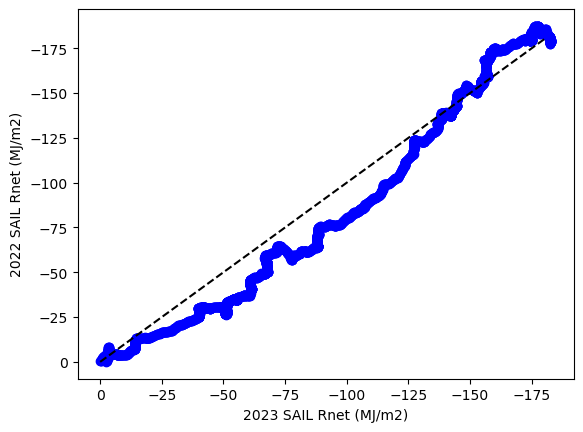

In [125]:
fig, ax = plt.subplots()
ax.scatter(w23_sail_sebs_rnet.cumsum()*(3600)/1e6, w22_sail_sebs_rnet.cumsum()*(3600)/1e6, label='R_net', color='blue')
ax.plot([-180,0], [-180,0], ls='--',color='k', label='1:1')
ax.set_xlabel('2023 SAIL Rnet (MJ/m2)')
ax.set_ylabel('2022 SAIL Rnet (MJ/m2)')
# flip the y axis and x-axis
ax.invert_yaxis()
ax.invert_xaxis()

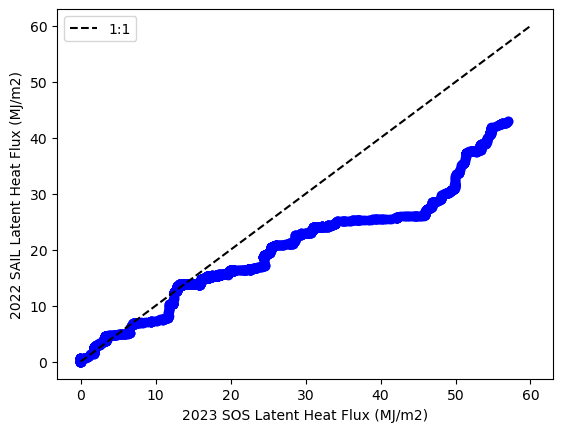

In [124]:
fig, ax = plt.subplots()
ax.scatter(-w23_sos_latent_heat_flux.cumsum()*3600/1e6, -w22_splash_asfs_latent_heat_flux.cumsum()*3600/1e6, color='blue')
ax.plot([0,60], [0,60], ls='--',color='k', label='1:1')
ax.set_xlabel('2023 SOS Latent Heat Flux (MJ/m2)')
ax.set_ylabel('2022 SAIL Latent Heat Flux (MJ/m2)')
ax.legend()

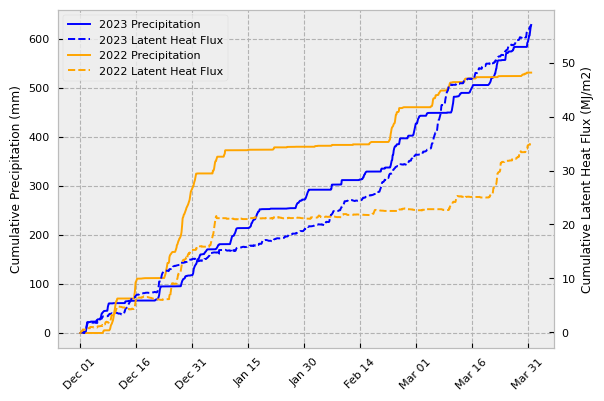

In [157]:
dummy_date_range = pd.date_range('2022-12-01', '2023-03-31', freq='15D')
plt.style.use('seaborn-v0_8-paper')
fig, ax = plt.subplots()
ax.plot(w23_sail_gts_met.precip_rate.cumsum().time.values, w23_sail_gts_met.precip_rate.cumsum().values, ls='-', label='2023 Precipitation', color='blue')
ax.plot([],[], ls='--', color='blue', label='2023 Latent Heat Flux')
ax.plot(w23_sail_gts_met.precip_rate.cumsum().time.values, w22_sail_gts_met.precip_rate.cumsum().values, ls='-', label='2022 Precipitation', color='orange')
ax.plot([],[], ls='--', color='orange', label='2022 Latent Heat Flux')
ax.set_ylabel('Cumulative Precipitation (mm)')
ax2 = ax.twinx()
ax2.plot(w23_sos_latent_heat_flux.cumsum().time.values, -w23_sos_latent_heat_flux.cumsum().values*3600/1e6, ls='--', color='blue')
ax2.plot(w23_sos_latent_heat_flux.cumsum().time.values, -w22_sail_ecor_latent_heat_flux.cumsum().values*3600/1e6, ls='--', color='orange')
ax2.set_ylabel('Cumulative Latent Heat Flux (MJ/m2)')

# on the x-axis, plot only the month and day
ax.set_xticks(dummy_date_range);
ax.set_xticklabels(dummy_date_range.strftime('%b %d'), rotation=45);
ax.legend()
ax.grid(True)
ax2.grid(False)
